In [1]:
import math
import torch
from torch import nn, Tensor

import matplotlib.pyplot as plt
import numpy as np

from positional_encoder import models, utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cpu


In [2]:
batch_size = 5
train_data, val_data, test_data, vocab = utils.get_wikitext2_data(batch_size, device)

train_data = train_data[:60000,:]
val_data = val_data[:6000,:]
test_data = test_data[:6000,:]

print(f'Training Data: {train_data.size()}')
print(f'Validation Data: {val_data.size()}')
print(f'Test Data: {test_data.size()}')

Training Data: torch.Size([60000, 5])
Validation Data: torch.Size([6000, 5])
Test Data: torch.Size([6000, 5])


In [3]:
idxs, batch = list(range(35,50)), 0
tokens = train_data[idxs, batch]
words = [vocab.lookup_token(token) for token in tokens]

print(f'tokens:\n{tokens}')
print(f'words:\n{words}')

tokens:
tensor([    8,  5790,   299,    12,   575,   232,    67,   452,    19, 13722,
            5,   757,     3,  2500,    17])
words:
['a', 'tactical', 'role', '@-@', 'playing', 'video', 'game', 'developed', 'by', 'sega', 'and', 'media', '.', 'vision', 'for']


In [4]:
class SinCosTextEncoder(nn.Module):
    def __init__(self, n_tokens: int, d_model: int, init_range):
        super().__init__()
        self.encoder = nn.Embedding(n_tokens, d_model)
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.d_model = d_model

    def forward(self, src: Tensor):
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
        """
        return self.encoder(src) * math.sqrt(self.d_model)


class SinCosPosEncoder(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()

        ############# YOUR CODE HERE #############
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        positional_encoding = torch.zeros(max_seq_len, 1, d_model)
        positional_encoding[:, 0, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 0, 1::2] = torch.cos(position * div_term)
        ##########################################

        self.register_buffer('positional_encoding', positional_encoding)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.positional_encoding[:x.size(0)]
        return self.dropout(x)

## Training Model

| epoch   1 |   200/  600 batches | lr 0.50 | ms/batch 63.36 | loss  7.49 | ppl  1795.15
| epoch   1 |   400/  600 batches | lr 0.50 | ms/batch 62.35 | loss  6.94 | ppl  1033.78
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 38.89s | valid loss  6.65 | valid ppl   773.39
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  600 batches | lr 0.45 | ms/batch 62.85 | loss  6.58 | ppl   717.98
| epoch   2 |   400/  600 batches | lr 0.45 | ms/batch 63.00 | loss  6.48 | ppl   650.00
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 39.52s | valid loss  6.47 | valid ppl   644.32
-----------------------------------------------------------------------------------------
| End of training | test loss  6.25 | test ppl   519.97


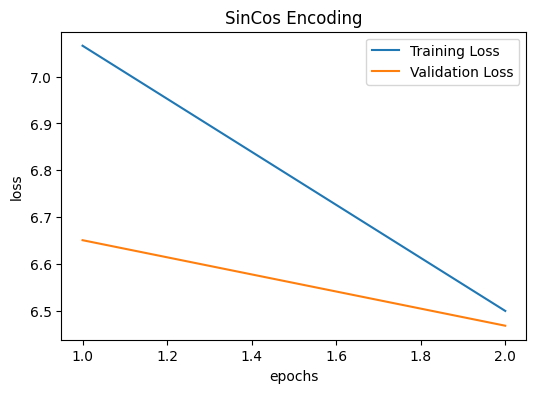

In [5]:
text_encoder = SinCosTextEncoder
pos_encoder = SinCosPosEncoder
n_tokens = len(vocab)

model = models.TransformerModel(text_encoder, pos_encoder, n_tokens=n_tokens).to(device)

criterion = nn.CrossEntropyLoss()
n_epochs = 2

sincos_train_loss, sincos_val_loss, sincos_test_loss = utils.train(model, train_data, val_data, test_data, n_tokens, n_epochs, criterion, device)
utils.plot_losses(title='SinCos Encoding',
                  losses={'Training Loss': sincos_train_loss, 'Validation Loss': sincos_val_loss})

## Sine Cosine Concatenation

In [9]:
class SinCosConcatTextEncoder(nn.Module):
    def __init__(self, n_tokens: int, d_model: int, init_range):
        super().__init__()

        ############# YOUR CODE HERE #############
        self.encoder = nn.Embedding(n_tokens, d_model // 2)
        ##########################################
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.d_model = d_model

    def forward(self, src: Tensor):
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
        """
        return self.encoder(src) * math.sqrt(self.d_model)


class SinCosConcatPosEncoder(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()

        ############# YOUR CODE HERE #############
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        positional_encoding = torch.zeros(max_seq_len, 1, d_model)
        positional_encoding[:, 0, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 0, 1::2] = torch.cos(position * div_term)
        positional_encoding = positional_encoding[:, :, :d_model // 2]
        ##########################################

        self.register_buffer('positional_encoding', positional_encoding)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        ############# YOUR CODE HERE #############
        x = torch.cat([x, self.positional_encoding[:x.size(0)].expand(-1, x.size()[1], -1)], dim=2)
        ##########################################
        return self.dropout(x)

| epoch   1 |   200/  600 batches | lr 0.50 | ms/batch 64.74 | loss  7.51 | ppl  1826.19
| epoch   1 |   400/  600 batches | lr 0.50 | ms/batch 61.65 | loss  6.93 | ppl  1018.51
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 38.83s | valid loss  6.65 | valid ppl   773.07
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  600 batches | lr 0.45 | ms/batch 61.85 | loss  6.57 | ppl   710.91
| epoch   2 |   400/  600 batches | lr 0.45 | ms/batch 62.99 | loss  6.46 | ppl   638.22
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 38.89s | valid loss  6.45 | valid ppl   634.86
-----------------------------------------------------------------------------------------
| End of training | test loss  6.25 | test ppl   516.49


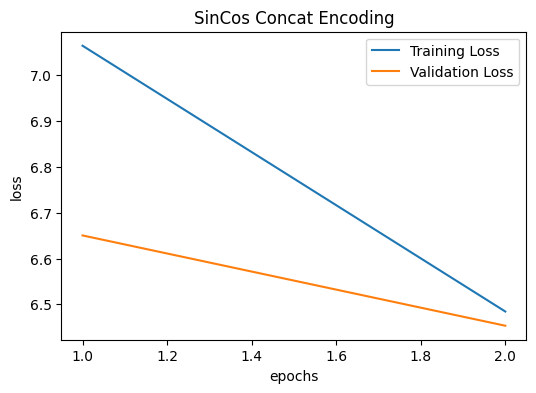

In [10]:
text_encoder = SinCosConcatTextEncoder
pos_encoder = SinCosConcatPosEncoder
n_tokens = len(vocab)

model = models.TransformerModel(text_encoder, pos_encoder, n_tokens=n_tokens).to(device)

criterion = nn.CrossEntropyLoss()
n_epochs = 2

sincoscat_train_loss, sincoscat_val_loss, sincoscat_test_loss = utils.train(model, train_data, val_data, test_data, n_tokens, n_epochs, criterion, device)
utils.plot_losses(title='SinCos Concat Encoding',
                  losses={'Training Loss': sincoscat_train_loss, 'Validation Loss': sincoscat_val_loss})

In [13]:
class IdxTextEncoder(nn.Module):
    def __init__(self, n_tokens: int, d_model: int, init_range):
        super().__init__()

        ############# YOUR CODE HERE #############
        self.encoder = nn.Embedding(n_tokens, d_model-1)
        ##########################################
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.d_model = d_model

    def forward(self, src: Tensor):
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
        """
        return self.encoder(src) * math.sqrt(self.d_model)


class IdxPosEncoder(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()

        ############# YOUR CODE HERE #############
        position = torch.arange(max_seq_len).view(-1, 1, 1)
        positional_encoding = position / max_seq_len
        ##########################################

        self.register_buffer('positional_encoding', positional_encoding)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        ############# YOUR CODE HERE #############
        x = torch.cat([x, self.positional_encoding[:x.size(0)].expand(-1, x.size()[1], -1)], dim=2)
        ##########################################
        return self.dropout(x)

| epoch   1 |   200/  600 batches | lr 0.50 | ms/batch 64.52 | loss  7.48 | ppl  1766.90
| epoch   1 |   400/  600 batches | lr 0.50 | ms/batch 63.21 | loss  6.88 | ppl   969.32
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 39.61s | valid loss  6.58 | valid ppl   723.27
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  600 batches | lr 0.45 | ms/batch 66.96 | loss  6.50 | ppl   666.60
| epoch   2 |   400/  600 batches | lr 0.45 | ms/batch 66.06 | loss  6.39 | ppl   597.18
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 40.97s | valid loss  6.39 | valid ppl   594.88
-----------------------------------------------------------------------------------------
| End of training | test loss  6.18 | test ppl   483.82


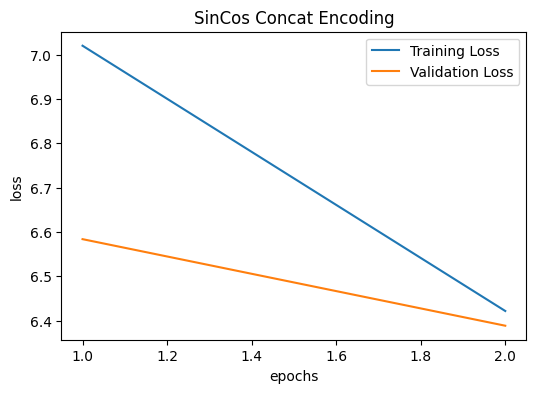

In [14]:
text_encoder = IdxTextEncoder
pos_encoder = IdxPosEncoder
n_tokens = len(vocab)

model = models.TransformerModel(text_encoder, pos_encoder, n_tokens=n_tokens).to(device)

criterion = nn.CrossEntropyLoss()
n_epochs = 2

idx_train_loss, idx_val_loss, idx_test_loss = utils.train(model, train_data, val_data, test_data, n_tokens, n_epochs, criterion, device)
utils.plot_losses(title='SinCos Concat Encoding',
                  losses={'Training Loss': idx_train_loss, 'Validation Loss': idx_val_loss})

In [17]:
class LearnedTextEncoder(nn.Module):
    def __init__(self, n_tokens: int, d_model: int, init_range):
        super().__init__()
        self.encoder = nn.Embedding(n_tokens, d_model)
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.d_model = d_model

    def forward(self, src: Tensor):
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
        """
        return self.encoder(src) * math.sqrt(self.d_model)


class LearnedPosEncoder(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()

        ############# YOUR CODE HERE #############
        positional_encoding = (torch.rand((max_seq_len, 1, d_model)) * 2) - 1
        positional_encoding = torch.nn.Parameter(positional_encoding)
        self.register_parameter('positional_encoding', positional_encoding)
        ##########################################

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.positional_encoding[:x.size(0)]
        return self.dropout(x)

In [ ]:
text_encoder = LearnedTextEncoder
pos_encoder = LearnedPosEncoder
n_tokens = len(vocab)

model = models.TransformerModel(text_encoder, pos_encoder, n_tokens=n_tokens).to(device)

criterion = nn.CrossEntropyLoss()
n_epochs = 2

learned_train_loss, learned_val_loss, learned_test_loss = utils.train(model, train_data, val_data, test_data, n_tokens, n_epochs, criterion, device)
utils.plot_losses(title='Learned Positional Encoding',
                  losses={'Training Loss': learned_train_loss, 'Validation Loss': learned_val_loss})

| epoch   1 |   200/  600 batches | lr 0.50 | ms/batch 65.19 | loss  7.51 | ppl  1833.01
| epoch   1 |   400/  600 batches | lr 0.50 | ms/batch 64.12 | loss  6.94 | ppl  1030.87
